# How to train your DragoNN tutorial 

## How to use this tutorial

This tutorial utilizes a Jupyter Notebook - an interactive computational enviroment that combines live code, visualizations, and explanatory text. The notebook is organized into a series of cells. You can run the next cell by cliking the play button:
![play button](./tutorial_images/play_button.png)
You can also run all cells in a series by clicking "run all" in the Cell drop-down menu:
![play all button](./tutorial_images/play_all_button.png)
Half of the cells in this tutorial contain code, the other half contain visualizations and explanatory text. Code, visualizations, and text in cells can be modified - you are encouraged to modify the code as you advance through the tutorial. You can inspect the implementation of a function used in a cell by following these steps:
![inspecting code](./tutorial_images/inspecting_code.png)

## Tutorial Overview
In this tutorial, we will:

    1) Simulate regulatory DNA sequence classification task
    2) Train DragoNN models of varying complexity to solve the simulation
    3) Interpret trained DragoNN models
    4) Show how to train your DragoNN on your own, non-simulated data and use it to interpret data

This tutorial is implemented in python (see this [online python course](https://www.udacity.com/course/programming-foundations-with-python--ud036) for an introduction).

We start by loading dragonn's tutorial utilities. Let's review properties of regulatory sequence while the utilities are loading

In [28]:
%reload_ext autoreload
%autoreload 2
from dragonn.tutorial_utils import *
%matplotlib inline

![sequence properties 1](./tutorial_images/sequence_properties_1.jpg)
![sequence properties 2](./tutorial_images/sequence_properties_2.jpg)
![sequence properties 3](./tutorial_images/sequence_properties_3.jpg)
![sequence properties 4](./tutorial_images/sequence_properties_4.jpg)

In this tutorial, we will simulate heterodimer motif grammar detection task. Specifically, we will simulate a "positive" class of sequences with a SIX5-ZNF143 grammar with relatively fixed spacing between the motifs and a negative class of sequences containing both motifs positioned independently:
![heterodimer simulation](./tutorial_images/heterodimer_simulation.jpg)
Here is an overview of the sequence simulation functions in the dragonn tutorial:
![sequence](./tutorial_images/sequence_simulations.png)

Let's run the print_available_simulations function and see it in action.

In [29]:
print_available_simulations()

simulate_differential_accessibility
simulate_heterodimer_grammar
simulate_motif_counting
simulate_motif_density_localization
simulate_multi_motif_embedding
simulate_single_motif_detection


## Getting simulation data

To get simulation data we:
    
    1) Define the simulation parameters
        - obtain description of simulation parameters using the print_simulation_info function
    2) Call the get_simulation_data function, which takes as input the simulation name and the simulation
    parameters, and outputs the simulation data.

We simulate the SIX5-ZNF143 heterodimer motif grammar using the "simulate_heterodimer_grammar" simulation function. To get a description of the simulation parameters we use the print_simulation_info function, which takes as input the simulation function name, and outputs documentation for the simulation including the simulation parameters:

In [30]:
print_simulation_info("simulate_motif_density_localization")


    Simulates two classes of seqeuences:
        - Positive class sequences with multiple motif instances
          in center of the sequence.
        - Negative class sequences with multiple motif instances
          anywhere in the sequence.
    The number of motif instances is uniformly sampled
    between minimum and maximum motif counts.

    Parameters
    ----------
    motif_name : str
        encode motif name
    seq_length : int
        length of sequence
    center_size : int
        length of central part of the sequence where motifs can be positioned
    min_motif_counts : int
        minimum number of motif instances
    max_motif_counts : int
        maximum number of motif instances
    num_pos : int
        number of positive class sequences
    num_neg : int
        number of negative class sequences
    GC_fraction : float
        GC fraction in background sequence

    Returns
    -------
    sequence_arr : 1darray
        Contains sequence strings.
    y : 1darra

Next, we define parameters for a heterodimer grammar simulation of 500bp long sequence, with 0.4 GC fraction, 10000 positive and negative sequences, with SIx5 and ZNF143 motifs spaced 2-10 bp apart in the positive sequences:

In [31]:
motif_density_localization_simulation_parameters = {
    "motif_name": "TAL1_known4",
    "seq_length": 1000,
    "center_size": 150,
    "min_motif_counts": 2,
    "max_motif_counts": 4, 
    "num_pos": 3000,
    "num_neg": 3000,
    "GC_fraction": 0.4}

We get the simulation data by calling the get_simulation_data function with the simulation name and the simulation parameters as inputs.

In [32]:
simulation_data = get_simulation_data("simulate_motif_density_localization",
                                      motif_density_localization_simulation_parameters,
                                      validation_set_size=1000, test_set_size=1000)

simulation_data provides training, validation, and test sets of input sequences X and sequence labels y. The inputs X are matrices with a one-hot-encoding of the sequences:
![one hot encoding](./tutorial_images/one_hot_encoding.png)
Here are the first 10bp of a sequence in our training data:

In [33]:
simulation_data.X_train[0, :, :, :10]

array([[[0, 0, 0, 1, 0, 1, 0, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 0, 1]]], dtype=int8)

This matrix represent the 10bp sequence AAATGGGCCG.

Next, we will provide a brief overview of DragoNNs and proceed to train a DragoNN to classify the sequences we simulated:
![classificatioin task](./tutorial_images/classification_task.jpg)

# DragoNN Models

A locally connected linear unit in a DragoNN model can represent a PSSM (part a). A sequence PSSM score is obtained by multiplying the PSSM across the sequence, thersholding the PSSM scores, and taking the max (part b). A PSSM score can also be computed by a DragoNN model with tiled locally connected linear units, amounting to a convolutional layer with a single convolutional filter representing the PSSM, followed by ReLU thersholding and maxpooling (part c).
![dragonn vs pssm](./tutorial_images/dragonn_and_pssm.jpg)
By utilizing multiple convolutional layers with multiple convolutional filters, DragoNN models can represent a wide range of sequence features in a compositional fashion:
![dragonn model figure](./tutorial_images/dragonn_model_figure.jpg)

# Getting a DragoNN model

The main DragoNN model class is SequenceDNN, which provides a simple interface to a range of models and methods to train, test, and interpret DragoNNs. SequenceDNN uses [keras](http://keras.io/), a deep learning library for [Theano](https://github.com/Theano/Theano) and [TensorFlow](https://github.com/tensorflow/tensorflow), which are popular software packages for deep learning.

To get a DragoNN model we:
    
    1) Define the DragoNN architecture parameters
        - obtain description of architecture parameters using the inspect_SequenceDNN() function
    2) Call the get_SequenceDNN function, which takes as input the DragoNN architecture parameters, and outputs a 
    randomly initialized DragoNN model.

To get a description of the architecture parameters we use the inspect_SequenceDNN function, which outputs documentation for the model class including the architecture parameters:

In [34]:
inspect_SequenceDNN()

Sequence DNN models.

Parameters
----------
seq_length : int, optional
    length of input sequence.
keras_model : instance of keras.models.Sequential, optional
    seq_length or keras_model must be specified.
num_tasks : int, optional
    number of tasks. Default: 1.
num_filters : list[int] | tuple[int]
    number of convolutional filters in each layer. Default: (15,).
conv_width : list[int] | tuple[int]
    width of each layer's convolutional filters. Default: (15,).
pool_width : int
    width of max pooling after the last layer. Default: 35.
L1 : float
    strength of L1 penalty.
dropout : float
    dropout probability in every convolutional layer. Default: 0.
verbose: int
    Verbosity level during training. Valida values: 0, 1, 2.

Returns
-------
Compiled DNN model.

Available methods:

deeplift
get_sequence_filters
in_silico_mutagenesis
plot_architecture
plot_deeplift
plot_in_silico_mutagenesis
predict
save
score
test
train


"Available methods" display what can be done with a SequenceDNN model. These include common operations such as training and testing the model, and more complex operations such as extracting insight from trained models. We define a simple DragoNN model with one convolutional layer with one convolutional filter, followed by maxpooling of width 35. 

In [35]:
one_filter_dragonn_parameters = {
    'seq_length': 1000,
    'num_filters': [1],
    'conv_width': [10],
    'pool_width': 35}

we get a radnomly initialized DragoNN model by calling the get_SequenceDNN function with one_filter_dragonn_parameters as the input

In [36]:
one_filter_dragonn = get_SequenceDNN(one_filter_dragonn_parameters)

## Training a DragoNN model

Next, we train the one_filter_dragonn by calling train_SequenceDNN with one_filter_dragonn and simulation_data as the inputs. In each epoch, the one_filter_dragonn will perform a complete pass over the training data, and update its parameters to minimize the loss, which quantifies the error in the model predictions. After each epoch, the code prints performance metrics for the one_filter_dragonn on the validation data. Training stops once the loss on the validation stops improving for multiple consecutive epochs. The performance metrics include balanced accuracy, area under the receiver-operating curve ([auROC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)), are under the precision-recall curve ([auPRC](https://en.wikipedia.org/wiki/Precision_and_recall)), and recall for multiple false discovery rates  (Recall at [FDR](https://en.wikipedia.org/wiki/False_discovery_rate)).

In [56]:
train_SequenceDNN(one_filter_dragonn, simulation_data)

Training model (* indicates new best result)...
Epoch 1:
Train Loss: 0.6848	Balanced Accuracy: 55.04%	 auROC: 0.574	 auPRC: 0.564
	Recall at 5%|10%|20% FDR: 0.1%|0.1%|0.3%	 Num Positives: 1996	 Num Negatives: 2004
Valid Loss: 0.7032	Balanced Accuracy: 50.12%	 auROC: 0.489	 auPRC: 0.476
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 490	 Num Negatives: 510 *
Epoch 2:
Train Loss: 0.6845	Balanced Accuracy: 55.37%	 auROC: 0.574	 auPRC: 0.564
	Recall at 5%|10%|20% FDR: 0.1%|0.1%|0.4%	 Num Positives: 1996	 Num Negatives: 2004
Valid Loss: 0.7025	Balanced Accuracy: 49.88%	 auROC: 0.489	 auPRC: 0.477
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 490	 Num Negatives: 510 *
Epoch 3:
Train Loss: 0.6845	Balanced Accuracy: 55.64%	 auROC: 0.574	 auPRC: 0.564
	Recall at 5%|10%|20% FDR: 0.1%|0.1%|0.3%	 Num Positives: 1996	 Num Negatives: 2004
Valid Loss: 0.7025	Balanced Accuracy: 50.14%	 auROC: 0.490	 auPRC: 0.478
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 490	 Num 

A single layer, single filter model doesn't learn this pattern. Let's look at the learning curve to demonstrate this visually:

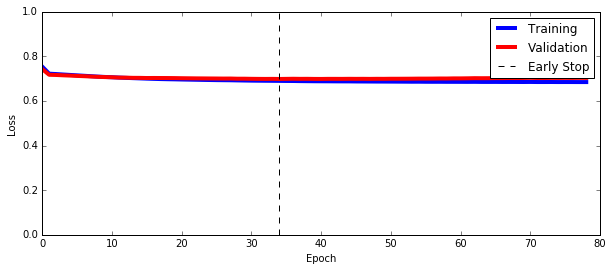

In [57]:
SequenceDNN_learning_curve(one_filter_dragonn)

# A multi-filter DragoNN model 
Next, we modify the model to have 15 convolutional filters instead of just one filter. Will this model learn the pattern?

Training model (* indicates new best result)...
Epoch 1:
Train Loss: 0.7119	Balanced Accuracy: 49.84%	 auROC: 0.498	 auPRC: 0.496
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 1996	 Num Negatives: 2004
Valid Loss: 0.7094	Balanced Accuracy: 51.01%	 auROC: 0.507	 auPRC: 0.491
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 490	 Num Negatives: 510 *
Epoch 2:
Train Loss: 0.7059	Balanced Accuracy: 51.62%	 auROC: 0.520	 auPRC: 0.514
	Recall at 5%|10%|20% FDR: 0.1%|0.1%|0.1%	 Num Positives: 1996	 Num Negatives: 2004
Valid Loss: 0.7041	Balanced Accuracy: 50.19%	 auROC: 0.521	 auPRC: 0.502
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 490	 Num Negatives: 510 *
Epoch 3:
Train Loss: 0.6964	Balanced Accuracy: 53.31%	 auROC: 0.543	 auPRC: 0.533
	Recall at 5%|10%|20% FDR: 0.1%|0.1%|0.1%	 Num Positives: 1996	 Num Negatives: 2004
Valid Loss: 0.6980	Balanced Accuracy: 51.59%	 auROC: 0.535	 auPRC: 0.513
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 490	 Num 

Epoch 26:
Train Loss: 0.1873	Balanced Accuracy: 92.90%	 auROC: 0.981	 auPRC: 0.980
	Recall at 5%|10%|20% FDR: 88.8%|96.0%|99.4%	 Num Positives: 1996	 Num Negatives: 2004
Valid Loss: 0.2459	Balanced Accuracy: 90.45%	 auROC: 0.964	 auPRC: 0.957
	Recall at 5%|10%|20% FDR: 69.4%|88.4%|98.2%	 Num Positives: 490	 Num Negatives: 510 *
Epoch 27:
Train Loss: 0.1877	Balanced Accuracy: 93.03%	 auROC: 0.982	 auPRC: 0.981
	Recall at 5%|10%|20% FDR: 89.7%|96.2%|99.4%	 Num Positives: 1996	 Num Negatives: 2004
Valid Loss: 0.2526	Balanced Accuracy: 90.19%	 auROC: 0.964	 auPRC: 0.957
	Recall at 5%|10%|20% FDR: 69.0%|88.8%|98.2%	 Num Positives: 490	 Num Negatives: 510
Epoch 28:
Train Loss: 0.1814	Balanced Accuracy: 92.93%	 auROC: 0.982	 auPRC: 0.981
	Recall at 5%|10%|20% FDR: 90.1%|96.5%|99.4%	 Num Positives: 1996	 Num Negatives: 2004
Valid Loss: 0.2414	Balanced Accuracy: 90.74%	 auROC: 0.964	 auPRC: 0.958
	Recall at 5%|10%|20% FDR: 69.2%|88.8%|98.2%	 Num Positives: 490	 Num Negatives: 510 *
Epoch 29:
Tr

Epoch 51:
Train Loss: 0.1443	Balanced Accuracy: 94.53%	 auROC: 0.988	 auPRC: 0.987
	Recall at 5%|10%|20% FDR: 94.0%|98.2%|99.8%	 Num Positives: 1996	 Num Negatives: 2004
Valid Loss: 0.2286	Balanced Accuracy: 90.33%	 auROC: 0.968	 auPRC: 0.962
	Recall at 5%|10%|20% FDR: 74.1%|91.2%|98.4%	 Num Positives: 490	 Num Negatives: 510 *
Epoch 52:
Train Loss: 0.1443	Balanced Accuracy: 94.53%	 auROC: 0.988	 auPRC: 0.987
	Recall at 5%|10%|20% FDR: 94.1%|98.3%|99.8%	 Num Positives: 1996	 Num Negatives: 2004
Valid Loss: 0.2326	Balanced Accuracy: 91.26%	 auROC: 0.968	 auPRC: 0.962
	Recall at 5%|10%|20% FDR: 74.7%|91.0%|98.4%	 Num Positives: 490	 Num Negatives: 510
Epoch 53:
Train Loss: 0.1416	Balanced Accuracy: 94.70%	 auROC: 0.988	 auPRC: 0.988
	Recall at 5%|10%|20% FDR: 94.1%|98.5%|99.9%	 Num Positives: 1996	 Num Negatives: 2004
Valid Loss: 0.2292	Balanced Accuracy: 90.85%	 auROC: 0.968	 auPRC: 0.962
	Recall at 5%|10%|20% FDR: 74.7%|91.2%|98.6%	 Num Positives: 490	 Num Negatives: 510
Epoch 54:
Trai

Epoch 76:
Train Loss: 0.1060	Balanced Accuracy: 96.37%	 auROC: 0.994	 auPRC: 0.994
	Recall at 5%|10%|20% FDR: 98.4%|99.8%|99.9%	 Num Positives: 1996	 Num Negatives: 2004
Valid Loss: 0.1992	Balanced Accuracy: 91.79%	 auROC: 0.975	 auPRC: 0.968
	Recall at 5%|10%|20% FDR: 83.1%|95.5%|99.2%	 Num Positives: 490	 Num Negatives: 510 *
Epoch 77:
Train Loss: 0.1033	Balanced Accuracy: 96.68%	 auROC: 0.994	 auPRC: 0.994
	Recall at 5%|10%|20% FDR: 98.4%|99.8%|99.9%	 Num Positives: 1996	 Num Negatives: 2004
Valid Loss: 0.1984	Balanced Accuracy: 92.21%	 auROC: 0.975	 auPRC: 0.968
	Recall at 5%|10%|20% FDR: 83.5%|95.9%|99.2%	 Num Positives: 490	 Num Negatives: 510 *
Epoch 78:
Train Loss: 0.1027	Balanced Accuracy: 96.80%	 auROC: 0.995	 auPRC: 0.994
	Recall at 5%|10%|20% FDR: 98.4%|99.8%|99.9%	 Num Positives: 1996	 Num Negatives: 2004
Valid Loss: 0.2004	Balanced Accuracy: 92.44%	 auROC: 0.975	 auPRC: 0.968
	Recall at 5%|10%|20% FDR: 83.7%|95.9%|99.2%	 Num Positives: 490	 Num Negatives: 510
Epoch 79:
Tr

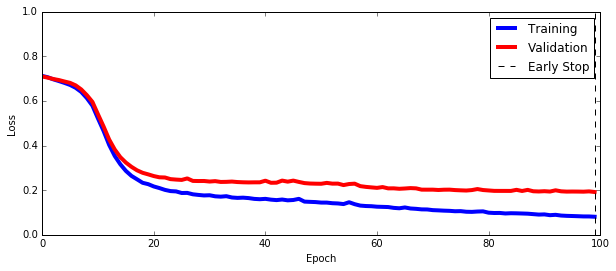

In [40]:
multi_filter_dragonn_parameters = {
    'seq_length': 1000,
    'num_filters': [15], ## notice the change from 1 filter to 15 filters
    'conv_width': [10],
    'pool_width': 35}
multi_filter_dragonn = get_SequenceDNN(multi_filter_dragonn_parameters)
train_SequenceDNN(multi_filter_dragonn, simulation_data)
SequenceDNN_learning_curve(multi_filter_dragonn)

It does learn and it overfits. Let's check if the learned filters capture the simulated pattern.

Plotting simulation motifs...


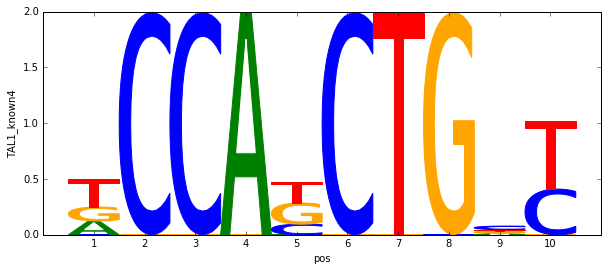

Visualizing convolutional sequence filters in SequenceDNN...


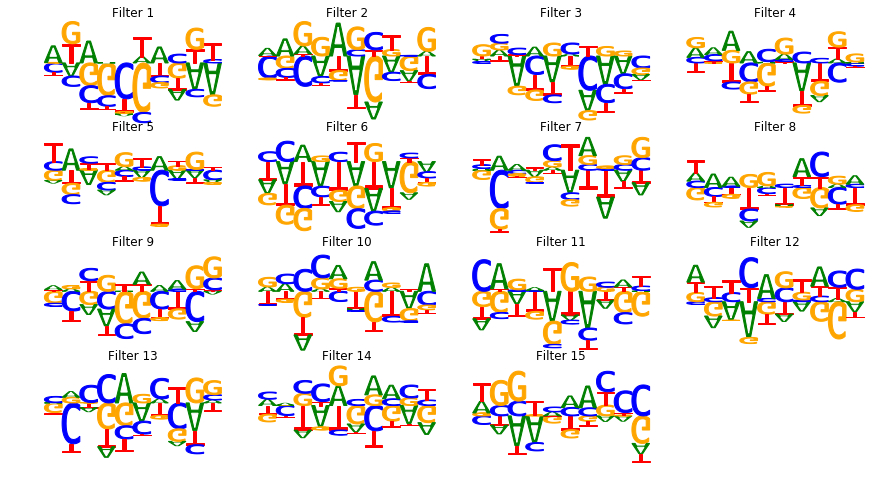

In [41]:
interpret_SequenceDNN_filters(multi_filter_dragonn, simulation_data)

Only some of the filters closesly match the simulated pattern. This illustrates that interpreting model parameters directly works partially for multi-filter models. Another way to deduce learned patterns is to examine feature importances for specific examples. Next, we explore methods for feature importance scoring.

# Interpreting data with a DragoNN model

Using in-silico mutagenesis (ISM) and [DeepLIFT](https://arxiv.org/pdf/1605.01713v2.pdf), we can obtain scores for specific sequence indicating the importance of each position in the sequence. To assess these methods we compare ISM and DeepLIFT scores to motif scores for each simulated motif at each position in the sequence. These motif scores represent the "ground truth" importance of each position because they are based on the motifs used to simulate the data. We plot provide comaprisons for a positive class sequence on the left and a negative class sequence on the right.

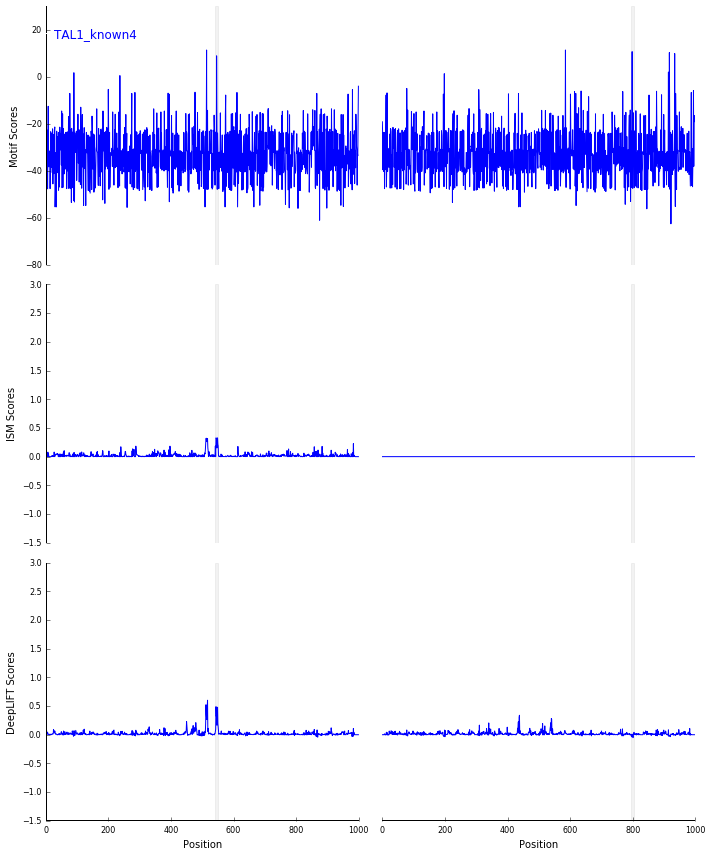

In [42]:
interpret_data_with_SequenceDNN(multi_filter_dragonn, simulation_data)

In the positive example (left side), ISM correctly highlights the two motif instances in the central 150bp. DeepLIFT highlights them as well. DeepLIFT also slightly highlights false positive feature on the left side but its score is sufficiently small that we can discriminate between the false positive feature and the true positive features. In the negative example (right side), ISM doesn't highlight anything but DeepLIFT a couple false positive feature almost as much as it highlights true positive features in the positive example.

# A multi-layer DragoNN model
Next, we train a 3 layer model for this task. Will it outperform the single layer model and to what extent will it overfit?

Training model (* indicates new best result)...
Epoch 1:
Train Loss: 0.7073	Balanced Accuracy: 50.14%	 auROC: 0.534	 auPRC: 0.526
	Recall at 5%|10%|20% FDR: 0.1%|0.1%|0.1%	 Num Positives: 1996	 Num Negatives: 2004
Valid Loss: 0.7172	Balanced Accuracy: 50.20%	 auROC: 0.489	 auPRC: 0.470
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 490	 Num Negatives: 510 *
Epoch 2:
Train Loss: 0.6816	Balanced Accuracy: 56.77%	 auROC: 0.601	 auPRC: 0.590
	Recall at 5%|10%|20% FDR: 0.1%|0.1%|0.1%	 Num Positives: 1996	 Num Negatives: 2004
Valid Loss: 0.6943	Balanced Accuracy: 52.13%	 auROC: 0.519	 auPRC: 0.498
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 490	 Num Negatives: 510 *
Epoch 3:
Train Loss: 0.6692	Balanced Accuracy: 61.82%	 auROC: 0.662	 auPRC: 0.648
	Recall at 5%|10%|20% FDR: 0.2%|0.7%|1.3%	 Num Positives: 1996	 Num Negatives: 2004
Valid Loss: 0.6923	Balanced Accuracy: 51.83%	 auROC: 0.533	 auPRC: 0.514
	Recall at 5%|10%|20% FDR: 0.2%|0.2%|0.2%	 Num Positives: 490	 Num 

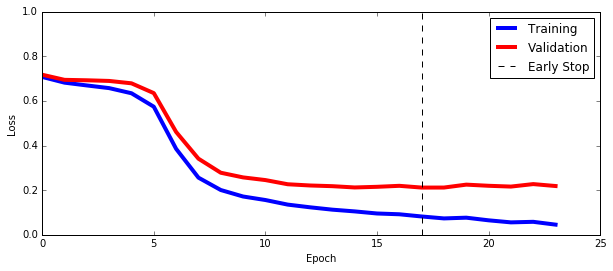

In [43]:
multi_layer_dragonn_parameters = {
    'seq_length': 1000,
    'num_filters': [15, 15, 15], ## notice the change to multiple filter values, one for each layer
    'conv_width': [10, 10, 10], ## convolutional filter width has been modified to 25 from 45
    'pool_width': 35}

multi_layer_dragonn = get_SequenceDNN(multi_layer_dragonn_parameters)
train_SequenceDNN(multi_layer_dragonn, simulation_data)
SequenceDNN_learning_curve(multi_layer_dragonn)

This model performs about the same as the single layer model but it overfits more. We will try to address that with dropout regularization. But first, what do the first layer filters look like?

Plotting simulation motifs...


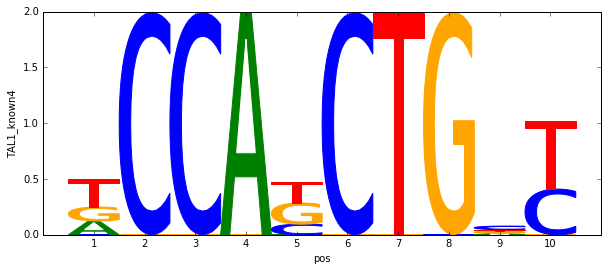

Visualizing convolutional sequence filters in SequenceDNN...


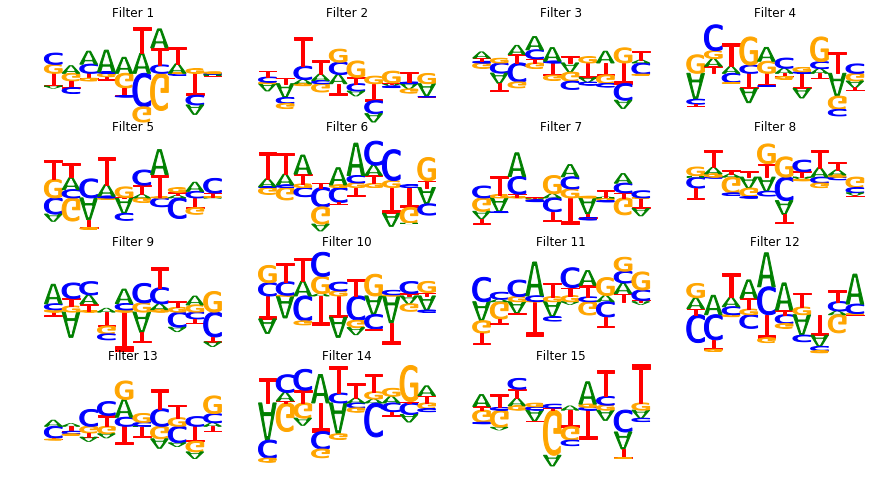

In [44]:
interpret_SequenceDNN_filters(multi_layer_dragonn, simulation_data)

The filters now make less sense than in the single layer model case. In multi-layered models, sequence features are learned compositionally across the layers. As a result, sequence filters in the first layer focus more on simple features that can be combined in higher layers to learn motif features more efficiently, and their interpretation becomes less clear based on simple visualizations. Let's see where ISM and DeepLIFT get us with this model.

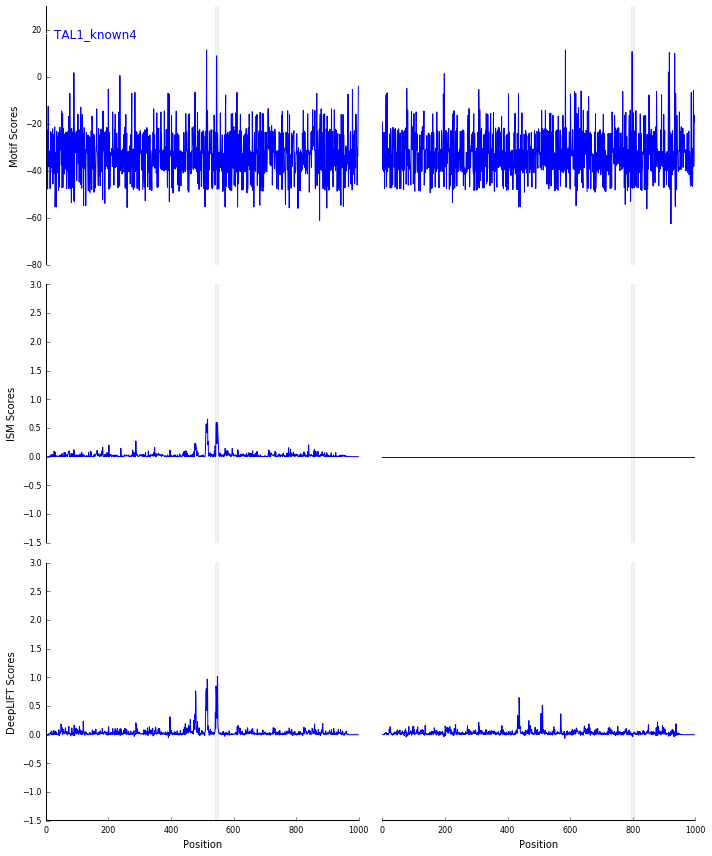

In [45]:
interpret_data_with_SequenceDNN(multi_layer_dragonn, simulation_data)

As in the single layer model case, ISM correctly highlights the two true positive features in the positive example (left side) and correctly ignores features in the negative example (right side). DeepLIFT still highlight the same false positive feature example in the positive example as before, but we can still separate it from the true positive features. In the negative example, it still highlights some false positive features.

# A regularized multi-layer DragoNN model
Next, we regularize the 3 layer using 0.2 dropout on every convolutional layer. Will dropout improve validation performance?

Training model (* indicates new best result)...
Epoch 1:
Train Loss: 0.7053	Balanced Accuracy: 50.05%	 auROC: 0.511	 auPRC: 0.500
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 1996	 Num Negatives: 2004
Valid Loss: 0.7007	Balanced Accuracy: 51.17%	 auROC: 0.521	 auPRC: 0.514
	Recall at 5%|10%|20% FDR: 0.2%|0.2%|0.2%	 Num Positives: 490	 Num Negatives: 510 *
Epoch 2:
Train Loss: 0.6979	Balanced Accuracy: 50.97%	 auROC: 0.537	 auPRC: 0.522
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 1996	 Num Negatives: 2004
Valid Loss: 0.6966	Balanced Accuracy: 50.87%	 auROC: 0.532	 auPRC: 0.533
	Recall at 5%|10%|20% FDR: 0.8%|0.8%|1.4%	 Num Positives: 490	 Num Negatives: 510 *
Epoch 3:
Train Loss: 0.6884	Balanced Accuracy: 54.13%	 auROC: 0.564	 auPRC: 0.545
	Recall at 5%|10%|20% FDR: 0.1%|0.1%|0.1%	 Num Positives: 1996	 Num Negatives: 2004
Valid Loss: 0.6916	Balanced Accuracy: 52.71%	 auROC: 0.534	 auPRC: 0.530
	Recall at 5%|10%|20% FDR: 0.8%|0.8%|3.7%	 Num Positives: 490	 Num 

Epoch 26:
Train Loss: 0.1059	Balanced Accuracy: 96.31%	 auROC: 0.995	 auPRC: 0.994
	Recall at 5%|10%|20% FDR: 98.7%|99.8%|100.0%	 Num Positives: 1996	 Num Negatives: 2004
Valid Loss: 0.1473	Balanced Accuracy: 94.97%	 auROC: 0.987	 auPRC: 0.983
	Recall at 5%|10%|20% FDR: 96.1%|99.2%|99.6%	 Num Positives: 490	 Num Negatives: 510 *
Epoch 27:
Train Loss: 0.1133	Balanced Accuracy: 95.96%	 auROC: 0.995	 auPRC: 0.994
	Recall at 5%|10%|20% FDR: 98.8%|99.9%|100.0%	 Num Positives: 1996	 Num Negatives: 2004
Valid Loss: 0.1573	Balanced Accuracy: 94.59%	 auROC: 0.988	 auPRC: 0.984
	Recall at 5%|10%|20% FDR: 96.3%|99.2%|99.6%	 Num Positives: 490	 Num Negatives: 510
Epoch 28:
Train Loss: 0.1202	Balanced Accuracy: 95.53%	 auROC: 0.995	 auPRC: 0.995
	Recall at 5%|10%|20% FDR: 98.8%|99.9%|100.0%	 Num Positives: 1996	 Num Negatives: 2004
Valid Loss: 0.1664	Balanced Accuracy: 94.30%	 auROC: 0.988	 auPRC: 0.984
	Recall at 5%|10%|20% FDR: 97.6%|99.2%|99.8%	 Num Positives: 490	 Num Negatives: 510
Epoch 29:
T

Epoch 51:
Train Loss: 0.0681	Balanced Accuracy: 97.50%	 auROC: 0.998	 auPRC: 0.998
	Recall at 5%|10%|20% FDR: 99.9%|100.0%|100.0%	 Num Positives: 1996	 Num Negatives: 2004
Valid Loss: 0.1189	Balanced Accuracy: 96.55%	 auROC: 0.992	 auPRC: 0.989
	Recall at 5%|10%|20% FDR: 98.6%|99.6%|100.0%	 Num Positives: 490	 Num Negatives: 510
Epoch 52:
Train Loss: 0.0620	Balanced Accuracy: 97.83%	 auROC: 0.998	 auPRC: 0.998
	Recall at 5%|10%|20% FDR: 99.9%|100.0%|100.0%	 Num Positives: 1996	 Num Negatives: 2004
Valid Loss: 0.1127	Balanced Accuracy: 96.64%	 auROC: 0.992	 auPRC: 0.989
	Recall at 5%|10%|20% FDR: 98.6%|99.4%|100.0%	 Num Positives: 490	 Num Negatives: 510
Epoch 53:
Train Loss: 0.0607	Balanced Accuracy: 97.88%	 auROC: 0.998	 auPRC: 0.998
	Recall at 5%|10%|20% FDR: 99.9%|100.0%|100.0%	 Num Positives: 1996	 Num Negatives: 2004
Valid Loss: 0.1134	Balanced Accuracy: 96.84%	 auROC: 0.992	 auPRC: 0.989
	Recall at 5%|10%|20% FDR: 98.6%|99.6%|100.0%	 Num Positives: 490	 Num Negatives: 510
Epoch 5

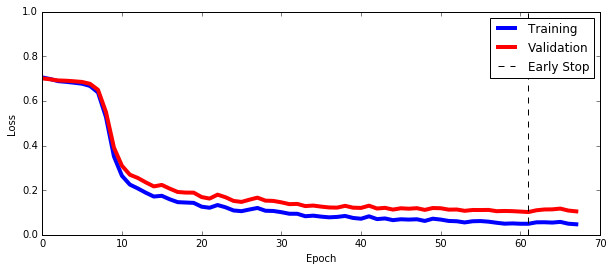

In [46]:
regularized_multi_layer_dragonn_parameters = {
    'seq_length': 1000,
    'num_filters': [15, 15, 15],
    'conv_width': [10, 10, 10],
    'pool_width': 35,
    'dropout': 0.2} ## we introduce dropout of 0.2 on every convolutional layer for regularization
regularized_multi_layer_dragonn = get_SequenceDNN(regularized_multi_layer_dragonn_parameters)
train_SequenceDNN(regularized_multi_layer_dragonn, simulation_data)
SequenceDNN_learning_curve(regularized_multi_layer_dragonn)

As expected, dropout decreased the overfitting this model displayed previously and increased validation performance. Let's see the effect on feature discovery.

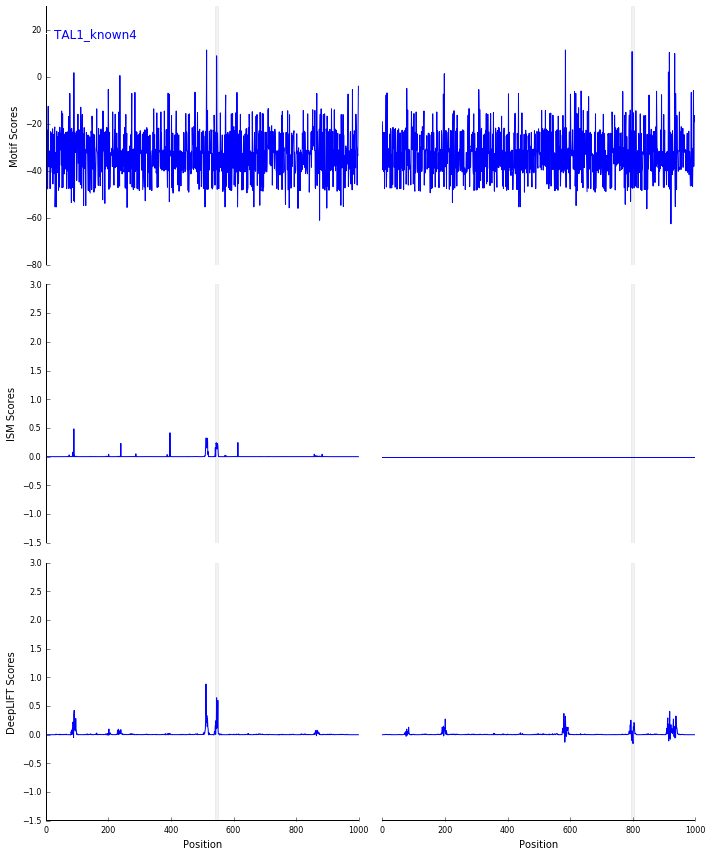

In [47]:
interpret_data_with_SequenceDNN(regularized_multi_layer_dragonn, simulation_data)

ISM now highlights a false positive feature in the positive example (left side) more than the true positive features. What happened? A sufficiently accurate model should not change its confidence that there are 2 or more features in the central 150 base pairs (bps) due to a single bp change. So it makes sense that in the limit of the "perfect" model ISM will actually lose its power to discover features in this example.

How about DeepLIFT? DeepLIFT now correctly highlights the only two positive features in the positive example and essentially ignores all the features in the negative example (right side). So it seems that in the limit of the "perfect" model, DeepLIFT gets closer to the true features.